## Part 3: Progress Report + Preliminary Findings

In [32]:
#Packages needed for this project
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import time
import re
import math
from collections import Counter
from geopy.geocoders import Nominatim

from sklearn.linear_model import LinearRegression, Ridge, RidgeCV ,Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler


#setting up limit to view maximum rows and columns
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 6000)

## Loading Data
Loading cleaned data from part2 capstone notebook where all the clearning/munging of each and every columns in the dataset has been handled and then stored into "df_air1_cleaned_01Jan2017.csv".

In [10]:
df=pd.read_csv('df_air1_cleaned_01Jan2017.csv')
df.drop(['Unnamed: 0','level_0','index'],axis=1, inplace=True)

In [11]:
df_all=df[['Date','Ground','Year','Month','Day','latitude','longititude','loccountry','Aboard_num','Fatalities_num','Fatalities_ratio',
          'Survived_num','Survival_ratio','Manufacturer_ac_type','reason_crash']]

In [12]:
print df_all.shape
df_all.head(2)

(4941, 15)


Date  Ground  Year  Month  Day   latitude  longititude  \
0  1921-08-24     1.0  1921      8   24  53.633976    -0.276514   
1  1921-09-06     0.0  1921      9    6  48.856614     2.352222   

       loccountry  Aboard_num  Fatalities_num  Fatalities_ratio  Survived_num  \
0  United Kingdom          46              46               1.0             0   
1          France           5               5               1.0             0   

   Survival_ratio Manufacturer_ac_type  reason_crash  
0             0.0                 None  engine error  
1             0.0                 None          None

In [7]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4941 entries, 0 to 4940
Data columns (total 15 columns):
Date                    4941 non-null object
Ground                  4941 non-null float64
Year                    4941 non-null int64
Month                   4941 non-null int64
Day                     4941 non-null int64
latitude                4941 non-null float64
longititude             4941 non-null float64
loccountry              4941 non-null object
Aboard_num              4941 non-null int64
Fatalities_num          4941 non-null int64
Fatalities_ratio        4941 non-null float64
Survived_num            4941 non-null int64
Survival_ratio          4941 non-null float64
Manufacturer_ac_type    4941 non-null object
reason_crash            4941 non-null object
dtypes: float64(5), int64(6), object(4)
memory usage: 579.1+ KB


In [367]:
print "Mean of Fatalities per accident: ",df_all['Fatalities_num'].mean()
print "Mean ratio of Fatalities ratio : ",df_all['Fatalities_ratio'].mean()

print "Mean of Survival per accident  : ",df_all['Survived_num'].mean()
print "Mean of ratio of Survival ratio: ",df_all['Survival_ratio'].mean()

Mean of Fatalities per accident:  20.2098765432
Mean ratio of Fatalities ratio :  0.825663508195
Mean of Survival per accident  :  8.02165553532
Mean of ratio of Survival ratio:  0.173526939082


### Correlation
Checking correlation of the features. The below features are highly correlated to fatalities ratio, fatalities number, survival number and survival ratio. Some of them are negatively correlated as well
- Ground
- Year, month
- latitude and longitude

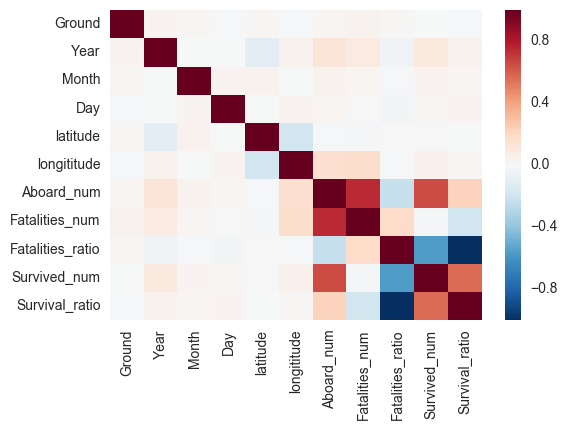

In [8]:
sns.heatmap(df_all.corr())

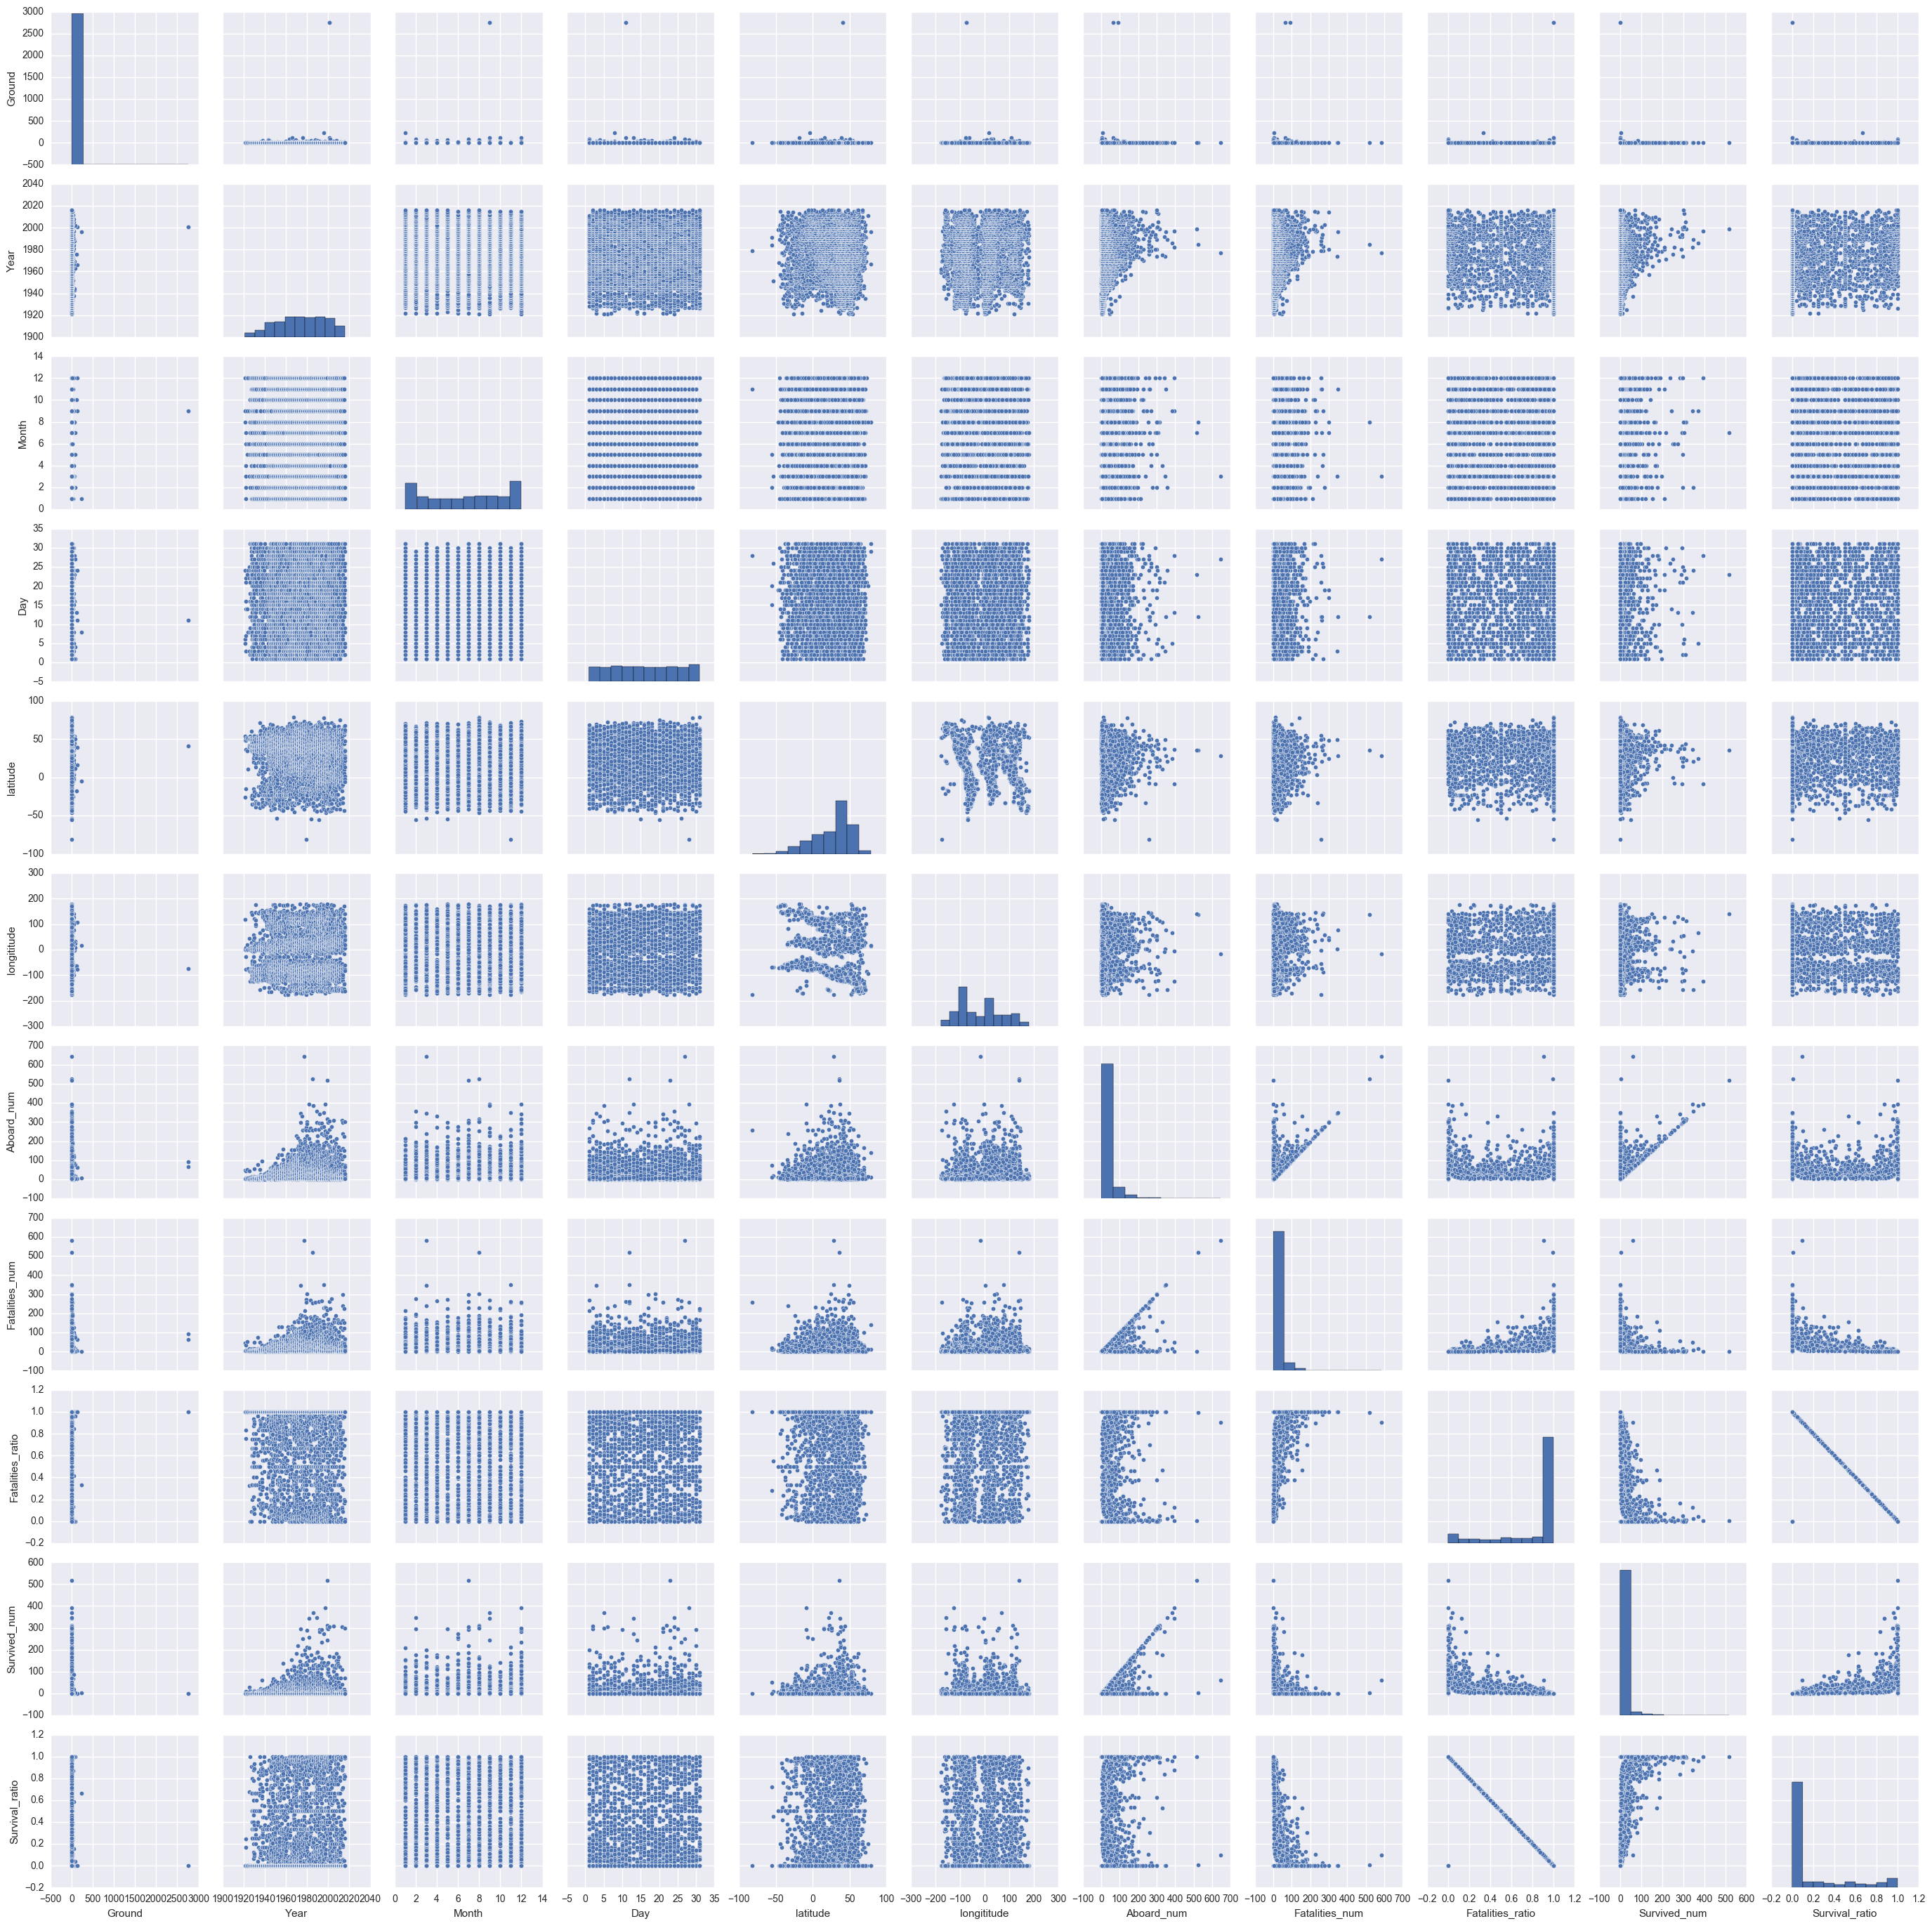

In [9]:
sns.pairplot(df_all)

In [13]:
df_all.describe()

Ground         Year        Month          Day     latitude  \
count  4941.000000  4941.000000  4941.000000  4941.000000  4941.000000   
mean      1.735276  1974.317749     6.624975    15.758753    27.238312   
std      55.633604    22.576165     3.553754     8.804540    24.741813   
min       0.000000  1921.000000     1.000000     1.000000   -81.499969   
25%       0.000000  1957.000000     3.000000     8.000000    11.410925   
50%       0.000000  1975.000000     7.000000    16.000000    34.540024   
75%       0.000000  1993.000000    10.000000    23.000000    44.103691   
max    2750.000000  2016.000000    12.000000    31.000000    78.901360   

       longititude   Aboard_num  Fatalities_num  Fatalities_ratio  \
count  4941.000000  4941.000000     4941.000000       4941.000000   
mean    -17.569013    28.231532       20.209877          0.825664   
std      83.959274    43.770406       33.223801          0.305824   
min    -177.376111     0.000000        0.000000          0.000000   
25%     -84.090725     5.000000        3.000000          0.766667   
50%     -21.425040    13.000000        9.000000          1.000000   
75%      37.617300    31.000000       23.000000          1.000000   
max     178.749400   644.000000      583.000000          1.000000   

       Survived_num  Survival_ratio  
count   4941.000000     4941.000000  
mean       8.021656        0.173527  
std       29.214337        0.304960  
min        0.000000        0.000000  
25%        0.000000        0.000000  
50%        0.000000        0.000000  
75%        3.000000        0.230769  
max      516.000000        1.000000

## Exploring the regression for Fatalities ratio, Survival ratio, Ground with Year data

- EDA for regression for fatalities ration, survival ration and Ground data with year as x values and see if there are any regresssion appreaing
- Ignoring all the fatalities where it is 0 and making that we can much better result

In [72]:
len(df_all[df_all['Fatalities_num']>0])

4877

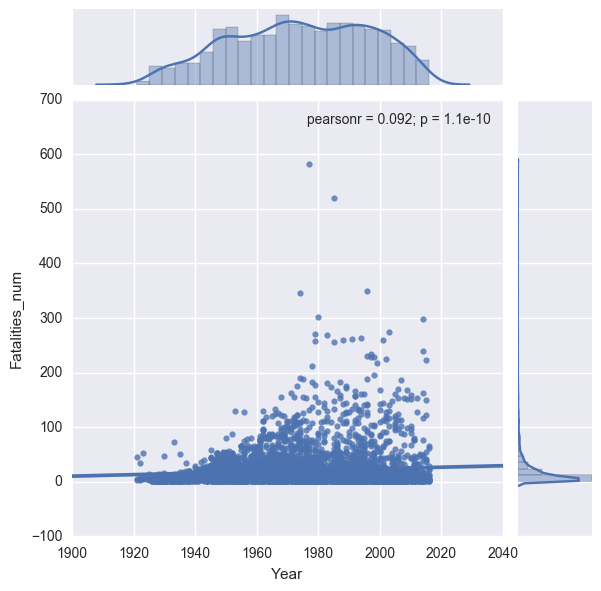

In [73]:
g = sns.jointplot(x="Year", y="Fatalities_num", data=df_all[df_all['Fatalities_num']<>0], kind="reg")

From the above we can see that year data is normally distributed but where as the Fatalities number has not been normally distributed. It might be skewed more towards right. Lets check the denisty of data where it more occurs, the most fatalities number occur between 0 to 100. Others are outliers

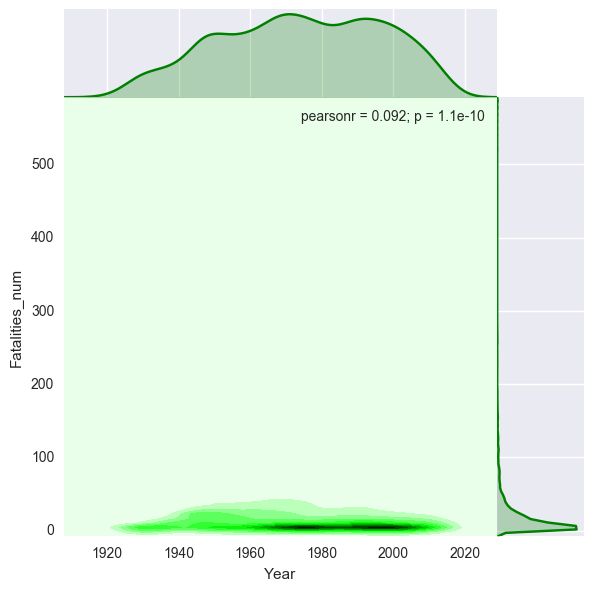

In [74]:
#finding the density of where the most occuring data
g = sns.jointplot("Year", "Fatalities_num", data=df_all[df_all['Fatalities_num']<>0],
                  kind="kde", space=0, color="g")

Similarly if we take closer look at the Survival number as well the more data is occuring between 0 to nearly 100

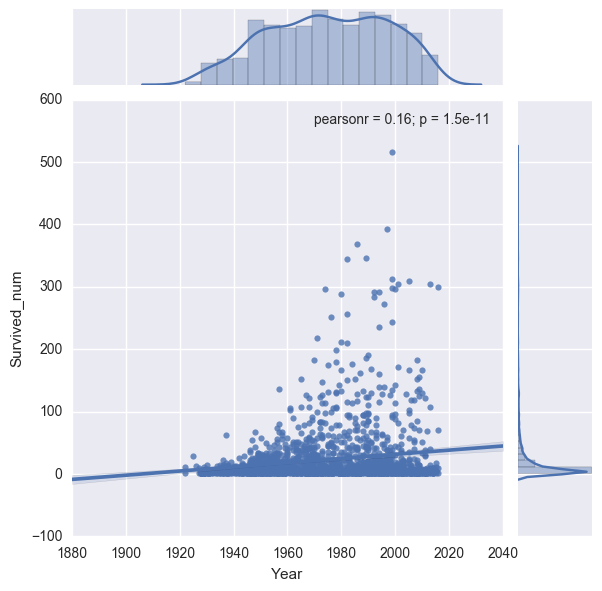

In [76]:
g = sns.jointplot(x="Year", y="Survived_num", data=df_all[df_all['Survived_num']<>0], kind="reg")

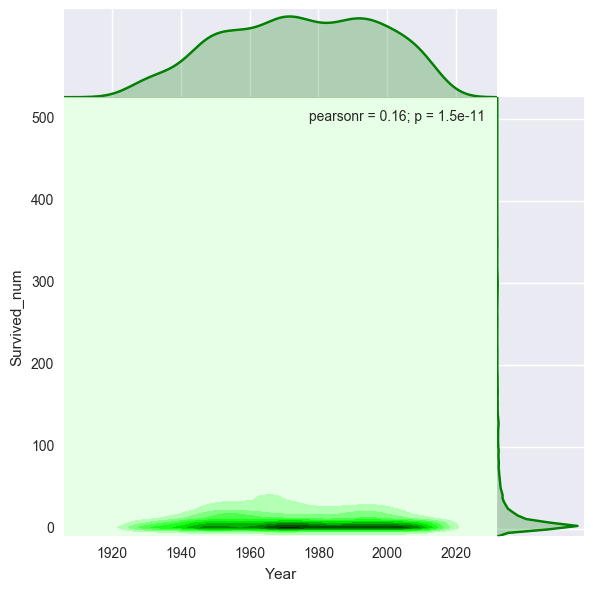

In [56]:
#finding the density of where the most occuring data
g = sns.jointplot("Year", "Survived_num", data=df_all[df_all['Survived_num']<>0],
                  kind="kde", space=0, color="g")

# 1. Convert categorical values into numbers as dummies

In [77]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4941 entries, 0 to 4940
Data columns (total 15 columns):
Date                    4941 non-null object
Ground                  4941 non-null float64
Year                    4941 non-null int64
Month                   4941 non-null int64
Day                     4941 non-null int64
latitude                4941 non-null float64
longititude             4941 non-null float64
loccountry              4941 non-null object
Aboard_num              4941 non-null int64
Fatalities_num          4941 non-null int64
Fatalities_ratio        4941 non-null float64
Survived_num            4941 non-null int64
Survival_ratio          4941 non-null float64
Manufacturer_ac_type    4941 non-null object
reason_crash            4941 non-null object
dtypes: float64(5), int64(6), object(4)
memory usage: 579.1+ KB


In [78]:
#country, manufacturer ac type, reasons for crash are categorical data and get them dummies below

In [79]:
df_country_dummy = pd.get_dummies(df_all['loccountry'],drop_first=True)
df_actype_dummy = pd.get_dummies(df_all['Manufacturer_ac_type'], drop_first=True)
df_reasoncrash_dummy = pd.get_dummies(df_all['reason_crash'], drop_first=True)

In [80]:
#merged above all dummies dataframe into one dataframe

In [81]:
df_all_dummies = pd.concat([df_country_dummy,df_actype_dummy,df_reasoncrash_dummy], axis=1)

In [82]:
df_all_dummies.shape # Total dummies itself has 300 features

(4941, 300)

In [87]:
#creating features columns to use for X
features = ['Ground', 'Year', 'Month', 'Day', 'latitude', 'longititude','Aboard_num','Survived_num',
            'Fatalities_num','Fatalities_ratio','Survival_ratio']

In [89]:
#final dataframe with dummies 
df_final = pd.concat([df_all[features],df_all_dummies],axis=1)
print df_final.shape

(4941, 311)


In [93]:
#Creating dataframe where non-zero fatalities number which will make more sense to the model
df_fatalities = df_final[df_final['Fatalities_num']<>0]
print "Fatalities non-zero dataframe shpae:",df_fatalities.shape

Fatalities non-zero dataframe shpae: (4877, 311)


In [105]:
#Creating dataframe where non-zero Survival number which will make more sense to the model
df_survivals = df_final[df_final['Survived_num']<>0]
print "This means considering only the crashes where some of the are survived. \nIgnoring those where all of them died"
print "Survival non-zero dataframe shpae:",df_survivals.shape

This means considering only the crashes where some of the are survived. 
Ignoring those where all of them died
Survival non-zero dataframe shpae: (1714, 311)


## Handling some zero fatalities before modeling
- There are 64 crashes where the airplanes are crashed but no one died.
- If we look at the reasons for the crash for these 64 rows they are may be due to weather conditions, take off landing and some cargo planes where pilot would have escaped from the crash using parachute
- Using above ignoring the fatalities where it is 0, there are some occurrence where airplace crash occured and no one has died, which may not be relevant to the model to predict the fatalities ratio where it is 0.

In [144]:
print "Total number of crashes where no one died:", len(df_all[df_all['Fatalities_num']==0])
print "Reasons for crash where no one died:"
df_all[df_all['Fatalities_num']==0]['reason_crash'].value_counts()

Total number of crashes where no one died: 64
Reasons for crash where no one died:


landing-takeoff       27
pilot error           11
shot down             10
weather conditions     8
None                   4
engine error           2
fuel exhaustion        1
others-cargo           1
Name: reason_crash, dtype: int64

## Handling some zero survivals before modeling
- There are 3277 crashes where the airplanes are crashed and all of them died.
- To be able to predict the survival ratio we might focus more on when accident happen and there are some people survived. In this case there are 1714 crashes where some people have survived. It is best to focus on if crash occurs and not all of them died then what is the ratio of survival.

In [148]:
print "Total number of crashes where no one survived:", len(df_all[df_all['Survived_num']==0])
print "Total number of crashes where people survived:", len(df_all[df_all['Survived_num']<>0])
print "Reasons for crash where no one survived:"
df_all[df_all['Survived_num']==0]['reason_crash'].value_counts()

Total number of crashes where no one survived: 3227
Total number of crashes where people survived: 1714
Reasons for crash where no one survived:


landing-takeoff       1046
weather conditions     873
None                   383
pilot error            276
shot down              219
engine error           211
stall                   71
due to fire             57
others-cargo            45
fuel exhaustion         24
others-missing          12
terrorism               10
Name: reason_crash, dtype: int64

## 2. Creating features(X) and target(y) variables for model 

In [120]:
new_features = ['Ground', 'Year', 'Month', 'Day', 'latitude', 'longititude','Aboard_num','Survived_num',
                'Fatalities_num']
y_feature = ['Fatalities_ratio','Survival_ratio']

In [501]:
#X for Fatalities 
Xf = df_fatalities
Xf = Xf.drop(['Fatalities_num','Fatalities_ratio','Survival_ratio'], axis=1)

In [337]:
Xs = df_survivals
Xs = Xs.drop(['Survived_num','Fatalities_ratio','Survival_ratio'], axis=1)

In [338]:
print "Fatalities X -------"
print "Total number of features in X :", Xf.shape[1]
print "Total number of rows in X :    ", Xf.shape[0]
print "Survivals X -------"
print "Total number of features in X :", Xs.shape[1]
print "Total number of rows in X :    ", Xs.shape[0]

Fatalities X -------
Total number of features in X : 308
Total number of rows in X :     4877
Survivals X -------
Total number of features in X : 308
Total number of rows in X :     1714


Creating two target variables here for prediction model. First would like to predict Fatalities ratio and then also would like to predict Survival ratio based on the available data
- First y is Fatalities ratio
- Second ys is Survival ratio



In [339]:
yf = df_fatalities['Fatalities_ratio']
yf.shape

(4877,)

In [340]:
ys = df_survivals['Survival_ratio']
ys.shape

(1714,)

## 3.1. Linear Regression model for Fatalities Ratio

As the target varibales are numeric value and best to start with linear regression model from sklearn which will show the basic understanding of our data with the model. The necessary packages have been imported.

We have already converted the necessary variables into dummies and asssigned X and y values for the model.

Then we are dividing the train and test test for our model with 80:20% split here.

In [502]:
# divinging the data into train and test set to avoid overfitting. 80:20 (Train and Test set) 
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf,yf,test_size=0.20,random_state=42)

In [503]:
#creating and fitting model
model_reg = LinearRegression()
model_reg_fit = model_reg.fit(Xf_train,yf_train)
predictions_reg = model_reg_fit.predict(Xf_test)

In [504]:
model_reg_mse = mean_squared_error(yf_test,predictions_reg)
model_reg_mae = mean_absolute_error(yf_test,predictions_reg)
model_reg_rmse= math.sqrt(mean_squared_error(yf_test, predictions_reg))
model_reg_r2 = r2_score(yf_test,predictions_reg)
print "Linear Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_reg)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_reg)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_reg))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_reg)

Linear Regression model metrics:
--------------------------------
Mean Squared Error: 	6.01654384505e+16
Mean Absolute Error: 	14078990.6554
Root MSE:		245286441.636
r^2 Score: 		-6.50311950251e+17


First glannce of linear regression model has provided some score to start with, which is 34% r^2 score. Relatively the error measures are also fine to start with, its not relatively good but something not higher or negatives. Lets visualise the predictions and see how it looks at first

				Predicting Fatalities Ratio per accident


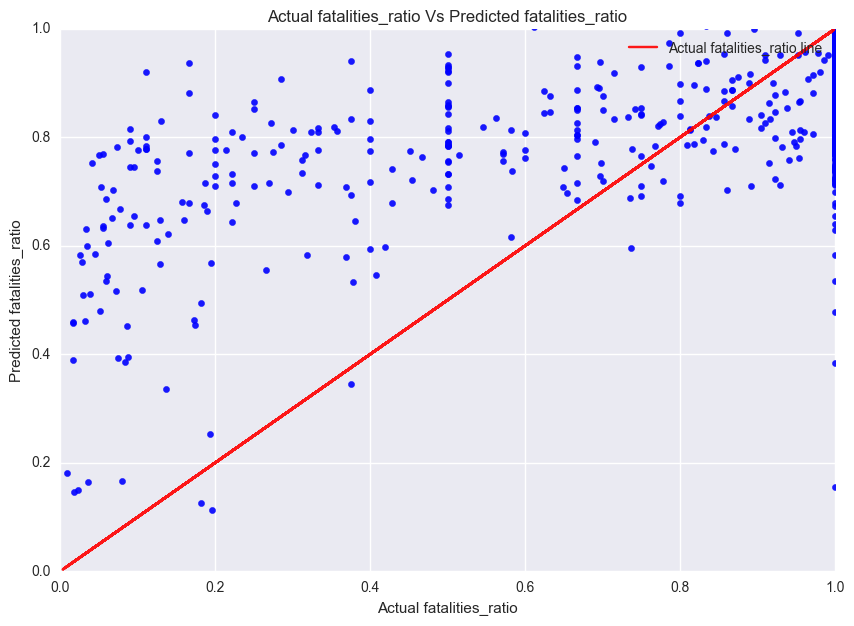

In [505]:
print "\t\t\t\tPredicting Fatalities Ratio per accident"
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_reg, color='blue', alpha=.9)
ax1.set(xlabel='Actual fatalities_ratio',ylabel='Predicted fatalities_ratio',
        title='Actual fatalities_ratio Vs Predicted fatalities_ratio',
       xlim=[0,1],
       ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',alpha=.9,label='Actual fatalities_ratio line')
plt.legend()
plt.show()

After reducing some noise initially be ignoring the those where there are no fatalities and progressed with those where there are some fatatlies in the acccident, produced some good linear fit. 

There are 308 features used to predict fatalities ratio, among which are 3 categorical features location of the crash, aircraft types, and reasons for crash. So getting dummies for these 3 values resulted in 300 features.

LinearRegression model has provided +ive r2 score which is 30%, eventhough its not good but its something to start as baseline and improve the model with some hyper parameters, so lets try Lasso and ridge model to futher improve the model performance.

## 3.2. Lasso Model for Fatalities ratio

Lasso Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0619656612769
Mean Absolute Error: 	0.189316261363
Root MSE:		0.248929028594
r^2 Score: 		0.330229928155


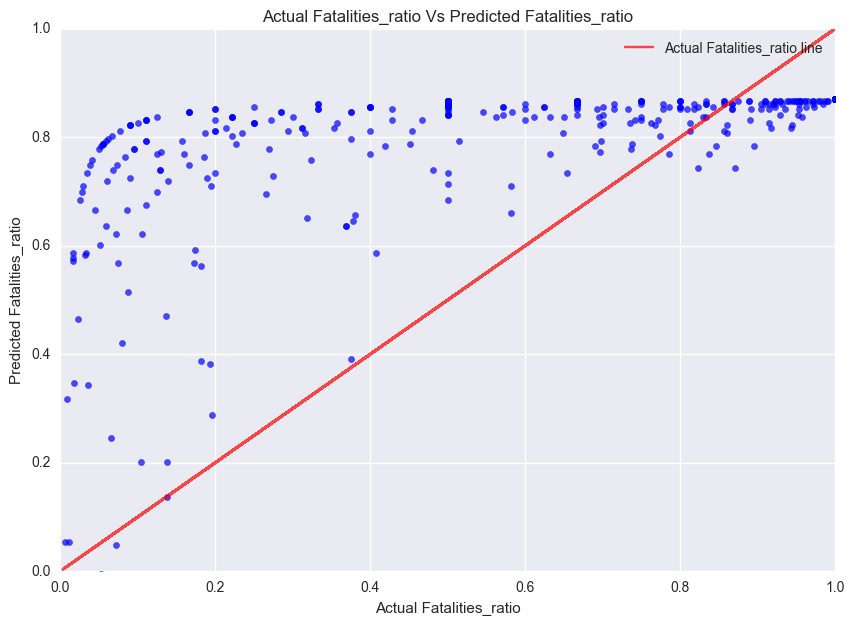

In [345]:
model_Lasso = Lasso()
model_Lasso_fit = model_Lasso.fit(Xf_train,yf_train)
predictions_lasso = model_Lasso_fit.predict(Xf_test)
model_lasso_mse = mean_squared_error(yf_test,predictions_lasso)
model_lasso_mae = mean_absolute_error(yf_test,predictions_lasso)
model_lasso_rmse= math.sqrt(mean_squared_error(yf_test, predictions_lasso))
model_lasso_r2 = r2_score(yf_test,predictions_lasso)
print "Lasso Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_lasso)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_lasso)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_lasso))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_lasso)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_lasso, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities_ratio Vs Predicted Fatalities_ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

## 3.3. LassoCV Model for Fatalities ratio

LassoCV Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0579396440079
Mean Absolute Error: 	0.177244446637
Root MSE:		0.240706551651
r^2 Score: 		0.373746059831


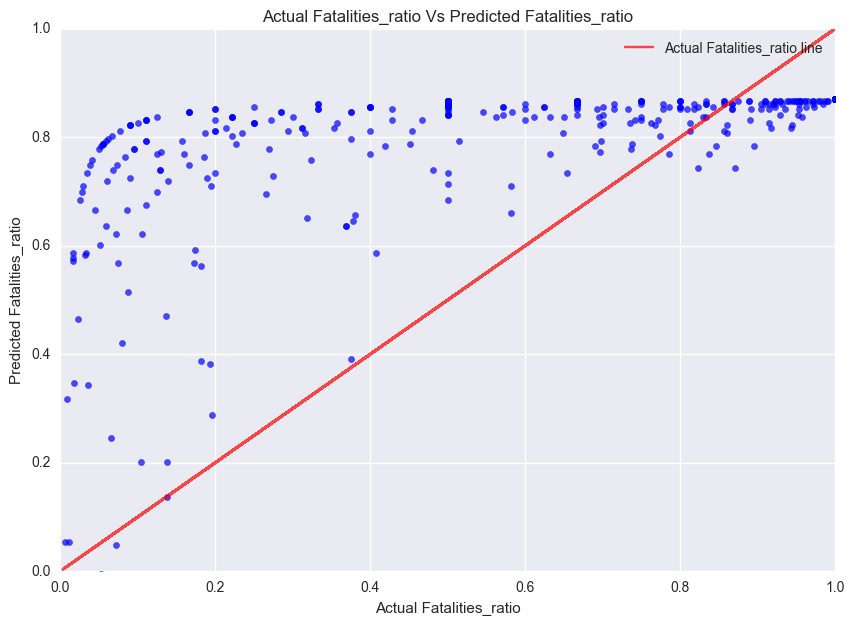

In [346]:
model_Lassocv = LassoCV(cv=5,n_alphas=300, normalize=False)
model_Lassocv_fit = model_Lassocv.fit(Xf_train,yf_train)
predictions_lassocv = model_Lassocv_fit.predict(Xf_test)
model_lassocv_mse = mean_squared_error(yf_test,predictions_lassocv)
model_lassocv_mae = mean_absolute_error(yf_test,predictions_lassocv)
model_lassocv_rmse= math.sqrt(mean_squared_error(yf_test, predictions_lassocv))
model_lassocv_r2 = r2_score(yf_test,predictions_lassocv)
print "LassoCV Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_lassocv)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_lassocv)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_lassocv))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_lassocv)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_lasso, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities_ratio Vs Predicted Fatalities_ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

From the above it seems the LassoCV hasn't improved anything even trying with different regularisation techniques. This shows that simple Lasso model itself provides much better results

## 3.4. Ridge Model for Fatalities ratio

Ridge Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0640583595462
Mean Absolute Error: 	0.190121291266
Root MSE:		0.253097529712
r^2 Score: 		0.307610518609


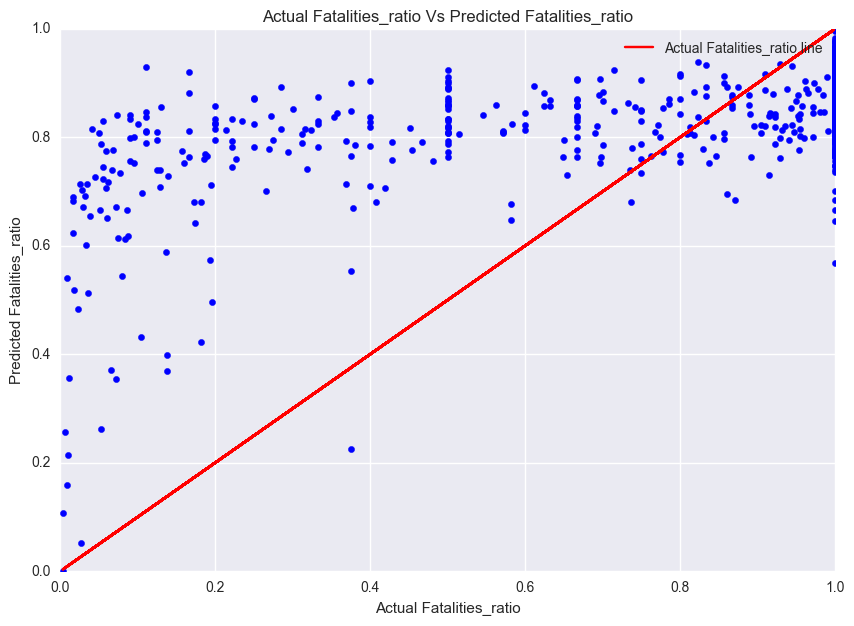

In [369]:
model_rd = Ridge(normalize=True)
model_rd_fit = model_rd.fit(Xf_train,yf_train)
predictions_ridge = model_rd_fit.predict(Xf_test)
model_ridge_mse = mean_squared_error(yf_test,predictions_ridge)
model_ridge_mae = mean_absolute_error(yf_test,predictions_ridge)
model_ridge_rmse= math.sqrt(mean_squared_error(yf_test, predictions_ridge))
model_ridge_r2 = r2_score(yf_test,predictions_ridge)
print "Ridge Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_ridge)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_ridge)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_ridge))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_ridge)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_ridge, color='blue')
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities_ratio Vs Predicted Fatalities_ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

Lasso and Ridge model has already uses some regularisation techniques. Simply appliying Lasso and Ridge model has improved the r^2 score significantly from normal linearRegression model. 

Lasso model has provided 34.4 score compared to ridge model which has 0.30. These are not best score but something to start for our model. Mean squared Error also improved in Ridge model by 0.01. From this Ridge model proves with good results. So lets try with Ridge CV model

## 3.5. RidgeCV Model for Fatalities ratio

RidgeCV Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0640583595462
Mean Absolute Error: 	0.190121291266
Root MSE:		0.253097529712
r^2 Score: 		0.307610518609
Best Alpha: 0.1


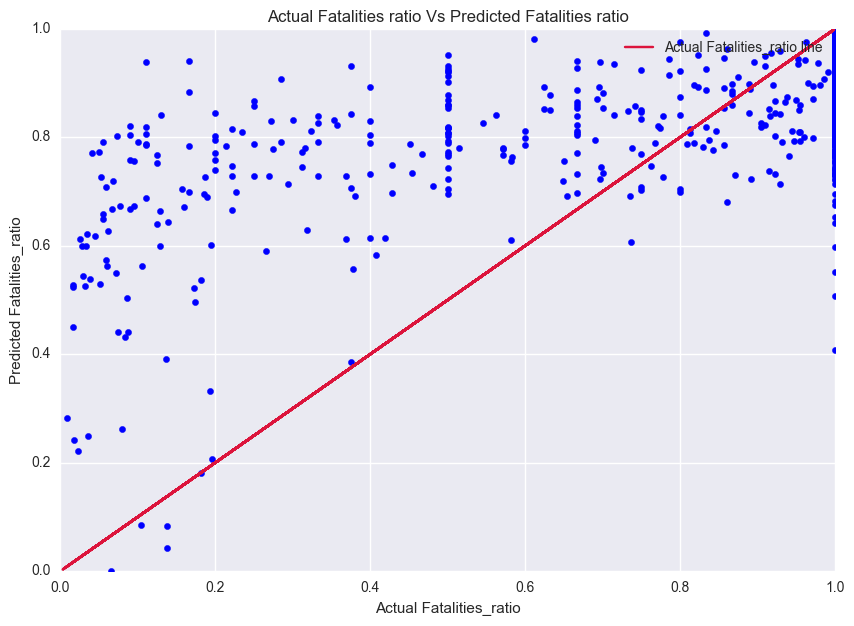

In [370]:
model_rdcv = RidgeCV(alphas=np.arange(-2.5, 2.5, 0.1),normalize=True)
model_rdcv_fit = model_rdcv.fit(Xf_train,yf_train)
predictions_ridgecv = model_rdcv_fit.predict(Xf_test)
model_ridgecv_mse = mean_squared_error(yf_test,predictions_ridgecv)
model_ridgecv_mae = mean_absolute_error(yf_test,predictions_ridgecv)
model_ridgecv_rmse= math.sqrt(mean_squared_error(yf_test, predictions_ridgecv))
model_ridgecv_r2 = r2_score(yf_test,predictions_ridgecv)
print "RidgeCV Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,predictions_ridge)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,predictions_ridge)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, predictions_ridge))

print 'r^2 Score: \t\t', r2_score(yf_test,predictions_ridge)
print "Best Alpha:", model_rdcv.alpha_
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, predictions_ridgecv, color='blue')
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities ratio Vs Predicted Fatalities ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='crimson',label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

RidgeCV model with multiple try of different values for alphas, the best is 0.1 and the r^2 score hasn't improved compared to the normal ridge model which means the regularisation techniques are not improving here.

Lets try tuning the Lasso and ridge model using grid search and see if there are any improvments

From the above Lasso and Ridge are better models in the case. More accurately Lasso model is best

## 3.5. Grid Search for Lasso and Ridge for  Fatalities ratio

In [349]:
params = {'alpha':np.logspace(-2.5,4.5,10)}
lasso = Lasso(max_iter=3000, fit_intercept=True)
gs = GridSearchCV(lasso,params,cv=10)
model = gs.fit(Xf_train,yf_train)
print 'Best alpha: ',model.best_params_
print 'Best score: ',model.best_score_
print 'Best estimator:', model.best_estimator_
model.grid_scores_

Best alpha:  {'alpha': 0.0031622776601683794}
Best score:  0.343405086899
Best estimator: Lasso(alpha=0.0031622776601683794, copy_X=True, fit_intercept=True,
   max_iter=3000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)


[mean: 0.34341, std: 0.13957, params: {'alpha': 0.0031622776601683794},
 mean: 0.32169, std: 0.14466, params: {'alpha': 0.018957356524063752},
 mean: 0.32264, std: 0.13458, params: {'alpha': 0.11364636663857249},
 mean: 0.30309, std: 0.08092, params: {'alpha': 0.68129206905796147},
 mean: 0.00015, std: 0.00408, params: {'alpha': 4.0842386526745216},
 mean: -0.00346, std: 0.00449, params: {'alpha': 24.484367468222267},
 mean: -0.00346, std: 0.00449, params: {'alpha': 146.77992676220705},
 mean: -0.00346, std: 0.00449, params: {'alpha': 879.92254356910746},
 mean: -0.00346, std: 0.00449, params: {'alpha': 5274.9970637026199},
 mean: -0.00346, std: 0.00449, params: {'alpha': 31622.776601683792}]

Lasso GridSearch Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0577341460952
Mean Absolute Error: 	0.176613891307
Root MSE:		0.240279308504
r^2 Score: 		0.375967231185


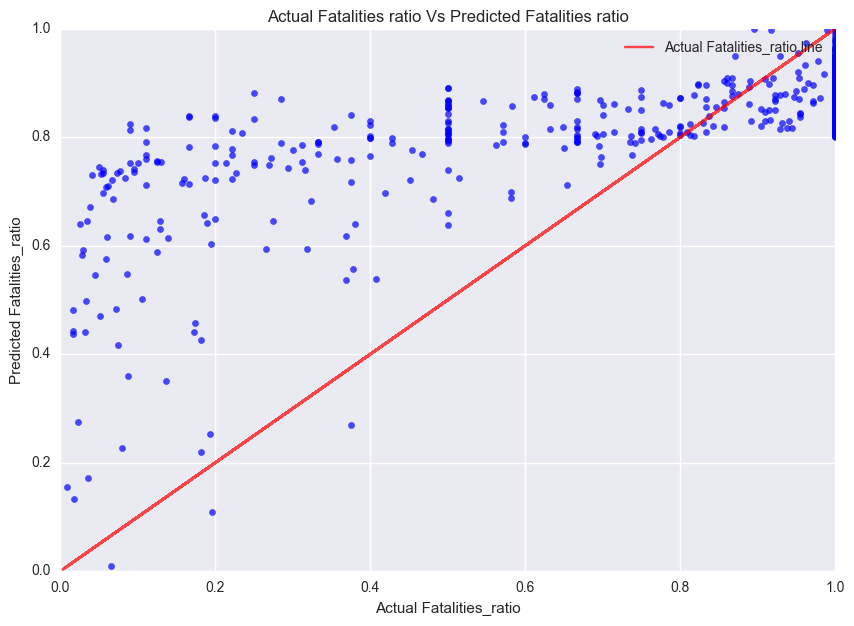

In [350]:
lasso_gs_model = model.best_estimator_.fit(Xf_train,yf_train)
lasso_gs_pred = lasso_gs_model.predict(Xf_test)

model_lasso_gs_mse = mean_squared_error(yf_test,lasso_gs_pred)
model_lasso_gs_mae = mean_absolute_error(yf_test,lasso_gs_pred)
model_lasso_gs_rmse= math.sqrt(mean_squared_error(yf_test, lasso_gs_pred))
model_lasso_gs_r2 = r2_score(yf_test,lasso_gs_pred)

print "Lasso GridSearch Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,lasso_gs_pred)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,lasso_gs_pred)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, lasso_gs_pred))

print 'r^2 Score: \t\t', r2_score(yf_test,lasso_gs_pred)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, lasso_gs_pred, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities ratio Vs Predicted Fatalities ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='red',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

In [351]:
#grid search for ridge model
params = {'alpha':np.logspace(-5,5,10)}
rid = Ridge(max_iter=3000)
gs = GridSearchCV(rid,params,cv=10)
model = gs.fit(Xf_train,yf_train)
print 'alpha: ',model.best_params_
print 'Best score: ',model.best_score_
model.grid_scores_

alpha:  {'alpha': 46.415888336127821}
Best score:  0.356336706065


[mean: 0.30502, std: 0.11390, params: {'alpha': 1.0000000000000001e-05},
 mean: 0.30504, std: 0.11390, params: {'alpha': 0.00012915496650148841},
 mean: 0.30534, std: 0.11391, params: {'alpha': 0.0016681005372000592},
 mean: 0.30751, std: 0.11407, params: {'alpha': 0.021544346900318846},
 mean: 0.31812, std: 0.11631, params: {'alpha': 0.27825594022071259},
 mean: 0.34447, std: 0.12362, params: {'alpha': 3.5938136638046259},
 mean: 0.35634, std: 0.13060, params: {'alpha': 46.415888336127821},
 mean: 0.34573, std: 0.13927, params: {'alpha': 599.48425031894214},
 mean: 0.32694, std: 0.14356, params: {'alpha': 7742.6368268112774},
 mean: 0.32472, std: 0.12101, params: {'alpha': 100000.0}]

Ridge GridSearch Regression model metrics:
--------------------------------
Mean Squared Error: 	0.0564476534669
Mean Absolute Error: 	0.171915491341
Root MSE:		0.237587149204
r^2 Score: 		0.389872582025


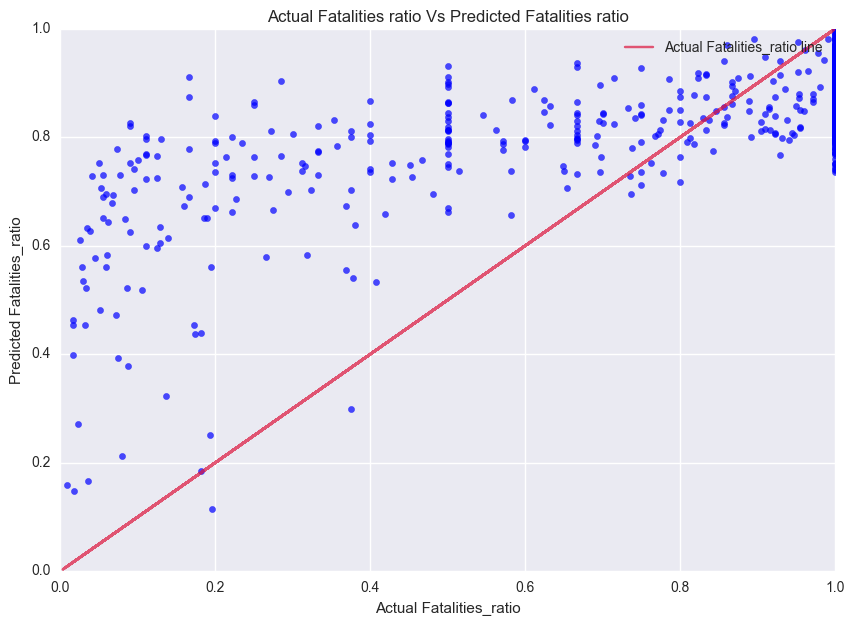

In [352]:
ridge_gs_model = model.best_estimator_.fit(Xf_train,yf_train)
ridge_gs_pred = ridge_gs_model.predict(Xf_test)

model_ridge_gs_mse = mean_squared_error(yf_test,ridge_gs_pred)
model_ridge_gs_mae = mean_absolute_error(yf_test,ridge_gs_pred)
model_ridge_gs_rmse= math.sqrt(mean_squared_error(yf_test, ridge_gs_pred))
model_ridge_gs_r2 = r2_score(yf_test,ridge_gs_pred)

print "Ridge GridSearch Regression model metrics:"
print "--------------------------------"
print 'Mean Squared Error: \t',mean_squared_error(yf_test,ridge_gs_pred)
print 'Mean Absolute Error: \t',mean_absolute_error(yf_test,ridge_gs_pred)
print 'Root MSE:\t\t', math.sqrt(mean_squared_error(yf_test, ridge_gs_pred))

print 'r^2 Score: \t\t', r2_score(yf_test,ridge_gs_pred)
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, ridge_gs_pred, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities ratio Vs Predicted Fatalities ratio',
        xlim=[0,1],
        ylim=[0,1])
ax1.plot(yf_test,yf_test,color='crimson',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

After exploring the gird search with mulptile alpha values the score hasn't improved very much. But it has increase 3% in r^2 score. But its always recommended to see whether gird search has provides any best results or not. In this case it has for ridge provided any notified results.

After trying with Linear Regression models for predicting fatalaties ratio and it wasn't progression much with the score till 35%, now its better try with Decision tree models like DecisionTreeRegressor, RandomForest and some regressor techniques

## Linear Regression model scores

From the below RidgeCV, LassoCV and Lasso gridsearch models are performaning similar and its bettter to visualise the score metric and compare between them. Before choosing this model, would like to try with decision tree and then choose the model

In [396]:
linear_score = {#'Linear_model':model_reg_r2,
               'Lasso_model':model_lasso_r2,
               'LassoCV_model':model_lassocv_r2,
               'Ridge_model':model_ridge_r2,
               'RidgeCV_model':model_ridgecv_r2,
               'Lasso_gridsearch':model_lasso_gs_r2}

x=linear_score.keys()
y=linear_score.values()
print x
print y

['Ridge_model', 'RidgeCV_model', 'Lasso_model', 'Lasso_gridsearch', 'LassoCV_model']
[0.3076105186094652, 0.37621561472771758, 0.33022992815512608, 0.37596723118523645, 0.37374605983135678]


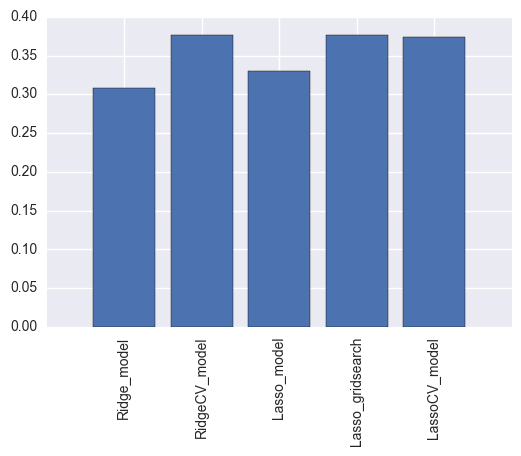

In [402]:
plt.bar(range(len(linear_score)), linear_score.values(), align='center',)
plt.xticks(range(len(linear_score)), list(linear_score.keys()),rotation='vertical')

plt.show()

## 3.6 Decision Tree Regressor

In [353]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingRegressor

In [356]:
#Creating decisiontree regressor
tree = DecisionTreeRegressor(random_state=1,max_depth=8)
tree.fit(Xf_train, yf_train)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

In [357]:
# make predictions
preds = tree.predict(Xf_test)

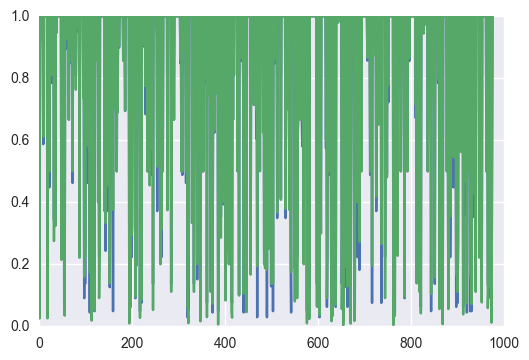

In [403]:
# print predictions and actual values
plt.plot(preds)
plt.plot(yf_test.values)

In [404]:
tree_score = r2_score(yf_test, preds)
print "r^2 score of Decision Tree",tree_score

r^2 score of Decision Tree 0.987768014512


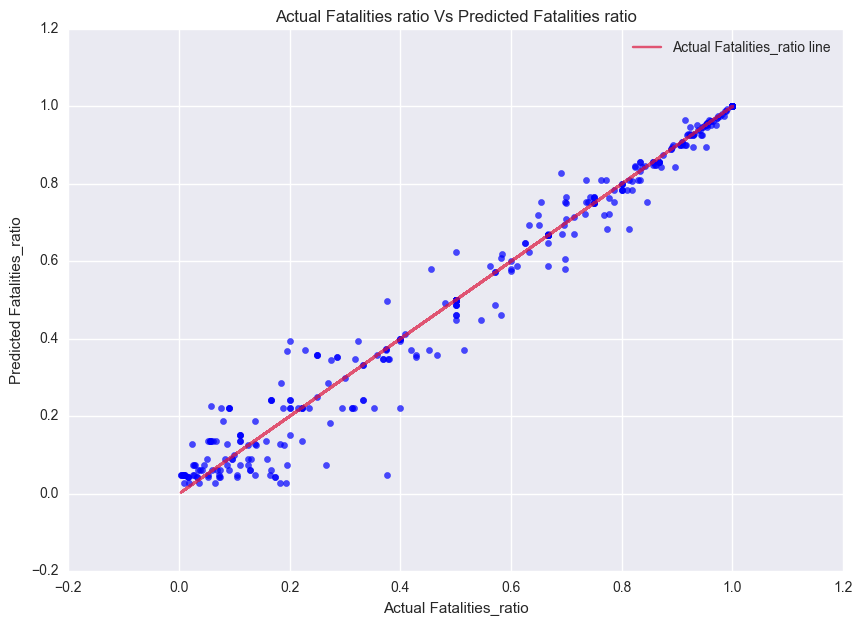

In [405]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(yf_test, preds, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities ratio Vs Predicted Fatalities ratio')
        #xlim=[0,1],
        #ylim=[0,1])
ax1.plot(yf_test,yf_test,color='crimson',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()


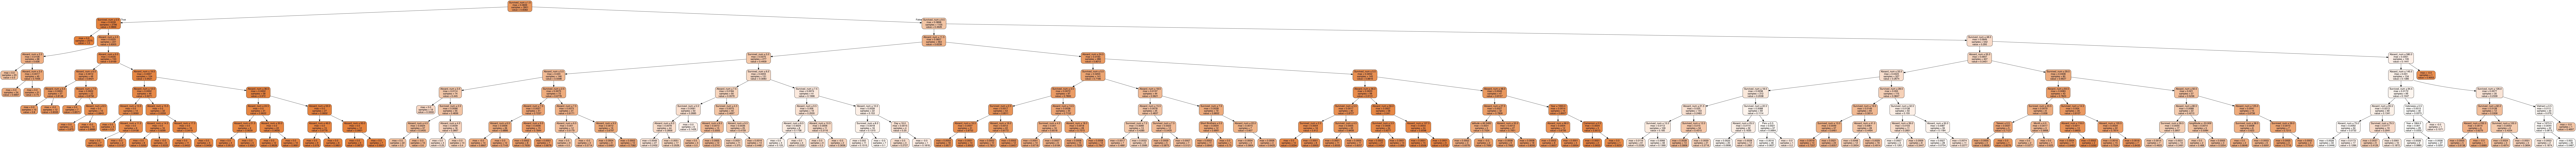

In [406]:
from IPython.display import Image
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
import pydot

dot_data = StringIO()  
export_graphviz(tree, out_file=dot_data,  
                feature_names=Xf.columns,  
                filled=True, rounded=True,  
                special_characters=True)  
graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png()) 

Finally realised the decision tree models are predicting very well with predicting fatalities ratio, then would like to try with not avoiding any of the accidents where there are no fatalities, those 64 rows. So I decided to introdue those and try with decision tree regressor and try how it works

In [506]:
Xf_ = df_final
Xf_ = Xf_.drop(['Fatalities_num','Fatalities_ratio','Survival_ratio'], axis=1)
Xf_.shape

(4941, 308)

In [507]:
yf_ = df_final['Fatalities_ratio']
yf_.shape

(4941,)

In [508]:
# divinging the data into train and test set to avoid overfitting. 80:20 (Train and Test set) 
Xf_train_, Xf_test_, yf_train_, yf_test_ = train_test_split(Xf_,yf_,test_size=0.20,random_state=42)

In [509]:
#Creating decisiontree regressor
tree_ = DecisionTreeRegressor(random_state=1,max_depth=8)
tree_.fit(Xf_train_, yf_train_)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=1,
           splitter='best')

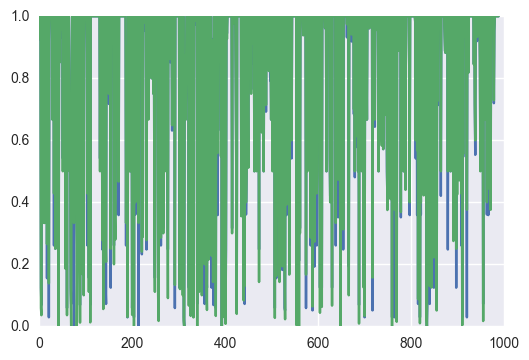

In [510]:
# make predictions
preds_ = tree_.predict(Xf_test_)
# print predictions and actual values
plt.plot(preds_)
plt.plot(yf_test_.values)

In [511]:
tree_score_ = r2_score(yf_test_, preds_)
print "r^2 score of Decision Tree",tree_score_

r^2 score of Decision Tree 0.9764413674


This is produced much better results even after introuducing those outliers and noise data back to the tree. But wanted do with label encoder raher than dummies and see if it still producing the similar results

In [443]:
df_tree = df_all

In [434]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
country_le = pd.DataFrame(le.fit_transform(df_tree['loccountry']),columns=['counrty_le'])
crash_le = pd.DataFrame(le.fit_transform(df_tree['reason_crash']),columns=['crash_le'])
actype_le = pd.DataFrame(le.fit_transform(df_tree['Manufacturer_ac_type']),columns=['actype_le'])

le_all = pd.concat([country_le, crash_le, actype_le], axis=1)

In [526]:
df_tree = pd.concat([df_tree,df_all_dummies], axis=1)
df_tree.drop(['loccountry','Manufacturer_ac_type','reason_crash','Date'], axis=1, inplace=True)

In [527]:
df_tree.head()

Ground  Year  Month  Day   latitude  longititude  Aboard_num  \
0     1.0  1921      8   24  53.633976    -0.276514          46   
1     0.0  1921      9    6  48.856614     2.352222           5   
2     0.0  1921     12    5 -25.874280   118.840646           3   
3     5.0  1922      1   14  48.856614     2.352222           5   
4     0.0  1922      2   21  36.850769   -76.285873          45   

   Fatalities_num  Fatalities_ratio  Survived_num  Survival_ratio  counrty_le  \
0              46          1.000000             0        0.000000         233   
1               5          1.000000             0        0.000000          75   
2               3          1.000000             0        0.000000          13   
3               5          1.000000             0        0.000000          75   
4              34          0.755556            11        0.244444         234   

   crash_le  actype_le  Aegean Sea  Afghanistan  Albania  Algeria  \
0         2         31           0            0        0        0   
1         0         31           0            0        0        0   
2         4         10           0            0        0        0   
3         0         31           0            0        0        0   
4         0         31           0            0        0        0   

   American Samoa  Andaman Sea  Angola  Antarctica  Antigua and Barbuda  \
0               0            0       0           0                    0   
1               0            0       0           0                    0   
2               0            0       0           0                    0   
3               0            0       0           0                    0   
4               0            0       0           0                    0   

   Argentina  Armenia  Atlantic Ocean  Australia  Austria  Azerbaijan  \
0          0        0               0          0        0           0   
1          0        0               0          0        0           0   
2          0        0               0          1        0           0   
3          0        0               0          0        0           0   
4          0        0               0          0        0           0   

   Bahrain  Baltic Sea  Bangladesh  Banihal Pass  Barbados  Batan Island  \
0        0           0           0             0         0             0   
1        0           0           0             0         0             0   
2        0           0           0             0         0             0   
3        0           0           0             0         0             0   
4        0           0           0             0         0             0   

   Bay of Bengal  Belarus  Belgium  Belize  Benin  Bermuda  Black Sea  \
0              0        0        0       0      0        0          0   
1              0        0        0       0      0        0          0   
2              0        0        0       0      0        0          0   
3              0        0        0       0      0        0          0   
4              0        0        0       0      0        0          0   

   Bolivia  Bosnia and Herzegovina  Botswana  Brazil  British Virgin Islands  \
0        0                       0         0       0                       0   
1        0                       0         0       0                       0   
2        0                       0         0       0                       0   
3        0                       0         0       0                       0   
4        0                       0         0       0                       0   

   Brunei  Bulgaria  Cambodia  Cameroon  Canada  Cape Verde  \
0       0         0         0         0       0           0   
1       0         0         0         0       0           0   
2       0         0         0         0       0           0   
3       0         0         0         0       0           0   
4       0         0         0         0       0           0   

   Caribbean Netherlands  Caribbean Sea  Central Afr

In [ ]:
X = df_tree[['Year','latitude','longititude','Aboard_num']]
y = df_tree['Fatalities_ratio']

In [522]:
# divinging the data into train and test set to avoid overfitting. 80:20 (Train and Test set) 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20,random_state=42)

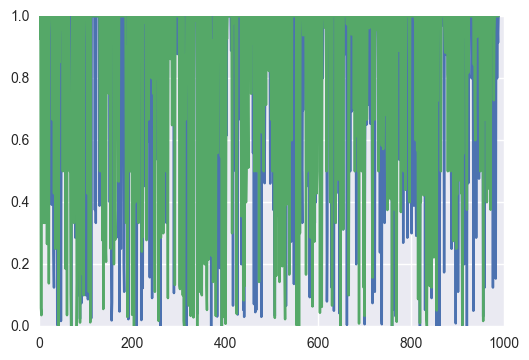

In [523]:
#Creating decisiontree regressor
treex= DecisionTreeRegressor(random_state=1,max_depth=50)
treex.fit(X_train, y_train)



# make predictions
predsx = treex.predict(X_test)
# print predictions and actual values
plt.plot(predsx)
plt.plot(y_test.values)

In [524]:
tree_scorex= r2_score(y_test, predsx)
print "r^2 score of Decision Tree",tree_scorex*100

r^2 score of Decision Tree -73.7728659791


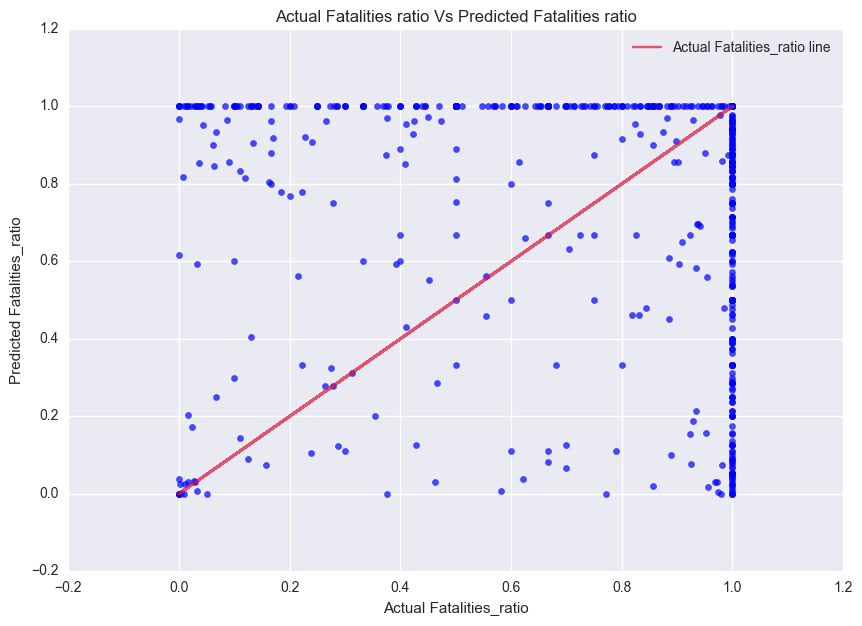

In [525]:
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(111)
ax1.scatter(y_test, predsx, color='blue', alpha=.7)
ax1.set(xlabel='Actual Fatalities_ratio',
        ylabel='Predicted Fatalities_ratio',
        title='Actual Fatalities ratio Vs Predicted Fatalities ratio')
        #xlim=[0,1],
        #ylim=[0,1])
ax1.plot(y_test,y_test,color='crimson',alpha=.7,label='Actual Fatalities_ratio line')
plt.legend()
plt.show()

After experimenting with the model and figured that 'Survival_num' (number of people survied per crash) has been feed into the decision tree model to predict the 'Fatalities_ratio' (rate of people died per crash) which is completely opposite. But after rectifying and removing the Survival num has resulted in -73.3% accurarcy and there are not clear fitting in this model. 

Next steps would be creating another derived feature 'Fatality_classification' (low, medium, high fatalaty) per accident might be helpful in predicting in much better, rather than accurate number of fatalities or ratio.

Also there are not enough features like fight journery duration, time of the flight, flight maintanence and weather report of accident place or any detailed malfunction features were not available to predict the fatalities accurately. Those would play much vital role in that.